##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This example uses a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a> for an image segmentation task.

## What is image segmentation?

This is a classification task, where each pixel is associated to a class. For this example we will use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)), and each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/fz/yn9wyn852cvd2npsc01_7fn40000gn/T/pip-req-build-vh2xkuch
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /private/var/folders/fz/yn9wyn852cvd2npsc01_7fn40000gn/T/pip-req-build-vh2xkuch
  Resolved https://github.com/tensorflow/examples.git to commit a23b78bb0bbd30d992bf9af7d9fbd66dc5cf70fa
  Preparing metadata (setup.py) ... done


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

The `pix2pix` library will help us to the upsampling part of the U-Net. The U-Net is a FCNN consisting of two phases, in the first we execute a downsampling process like in a CNN, while the second phase we execute an upsampling process to recover a feature map with the same size of the input image.

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

## Get Training and Test Sets

 We normalize the pixel values to be in the  `[0, 1]`. Finally, the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

The `load_image` function gets an image and the mask, and resize them to $128 \times 128$, and theb we normalize it with the method defined above. To resize a mask we use the nearest neighbors strategy.

In [7]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (128, 128),
        method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

We can use tensorflow data processing techniques for the training and test sets, but first we define some constants that will be helpful for that task.

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Now we define our training and test sets.

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.

**Note: There is a current [bug](https://github.com/keras-team/keras/issues/17457) ongoing with the function `tf.keras.layers.RandomFlip`, so we are not using the `Augment` function in the current example.**

In [10]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    # .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2023-04-28 14:04:07.379799: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


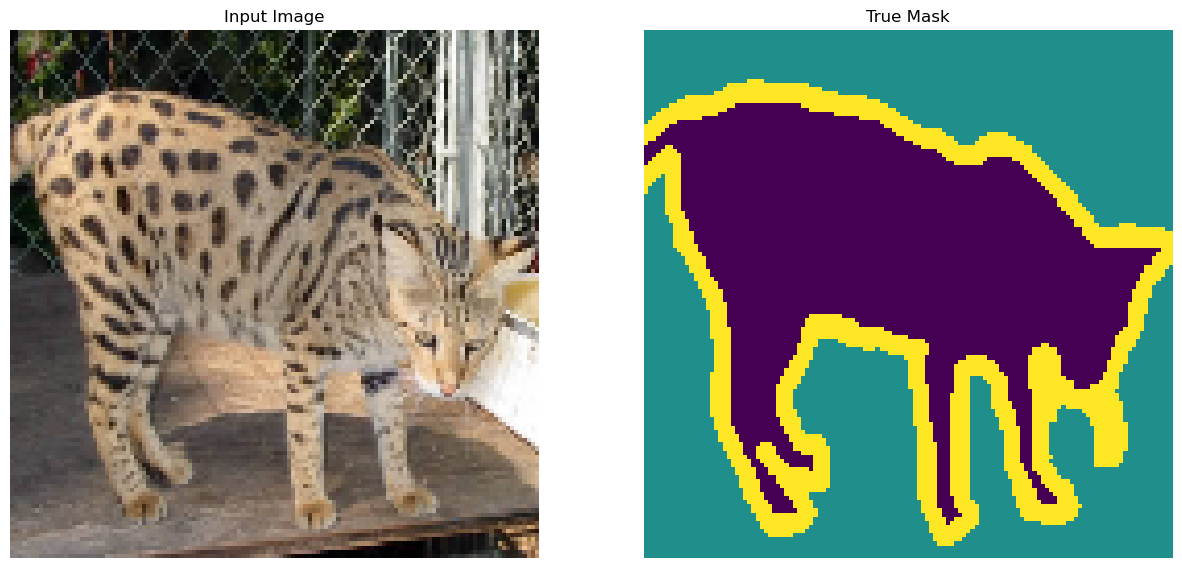

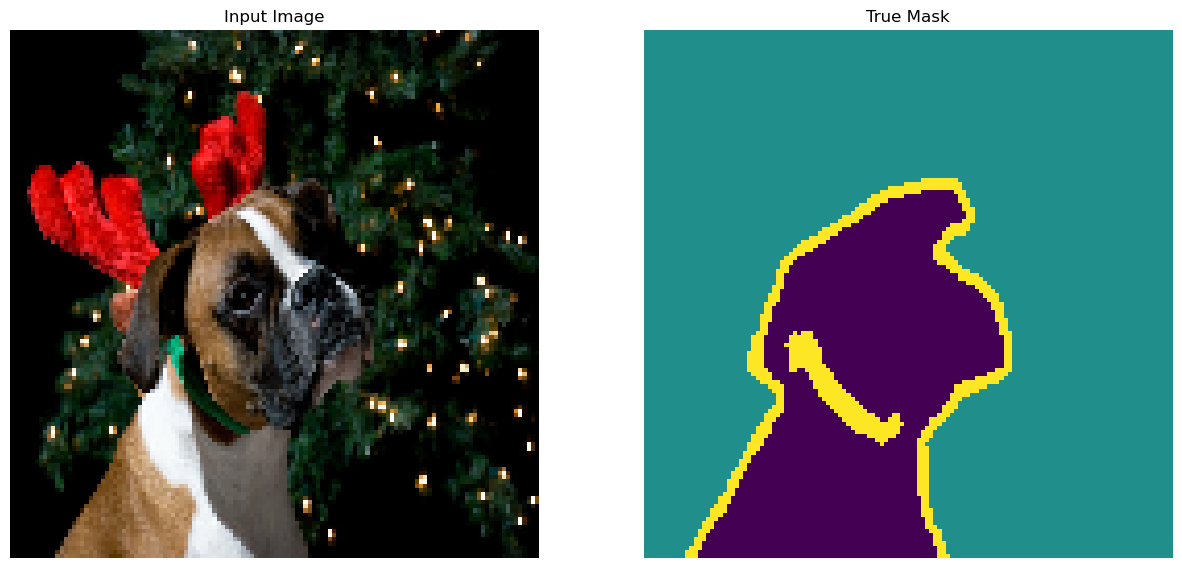

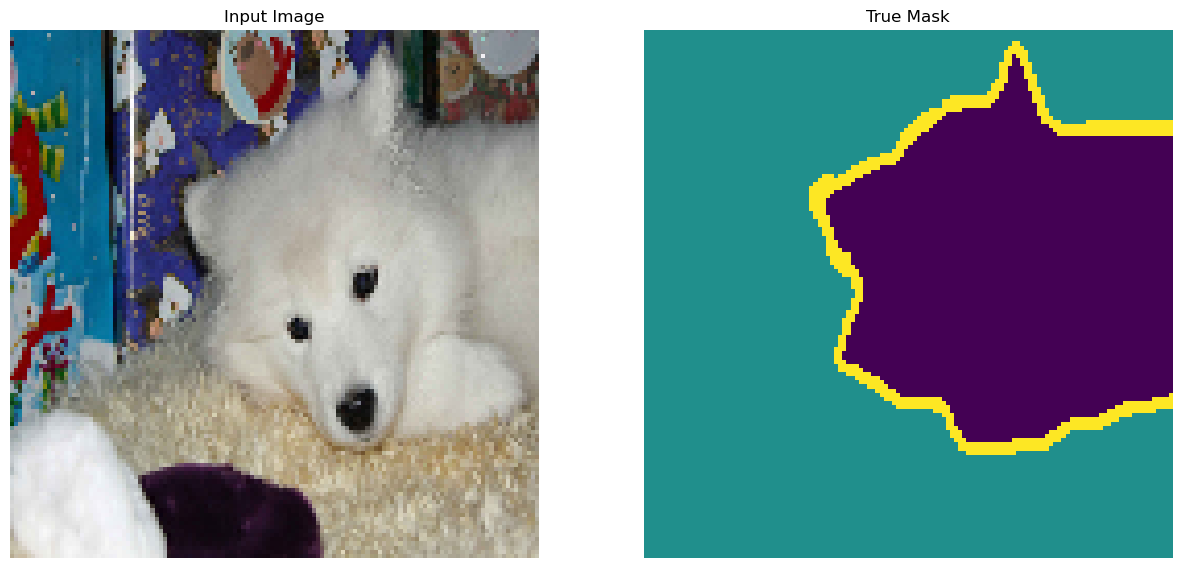

2023-04-28 14:04:08.251797: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
for images, masks in train_batches.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler).

The encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.


In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

The model will upsample the first intermediate layer and add it (concatenate) with the next one, the we continue upsampling the result and add the remaining intermediate layers in order.

In [16]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,padding='same')  #64x64 -> 128x128
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

**Note: The number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.**

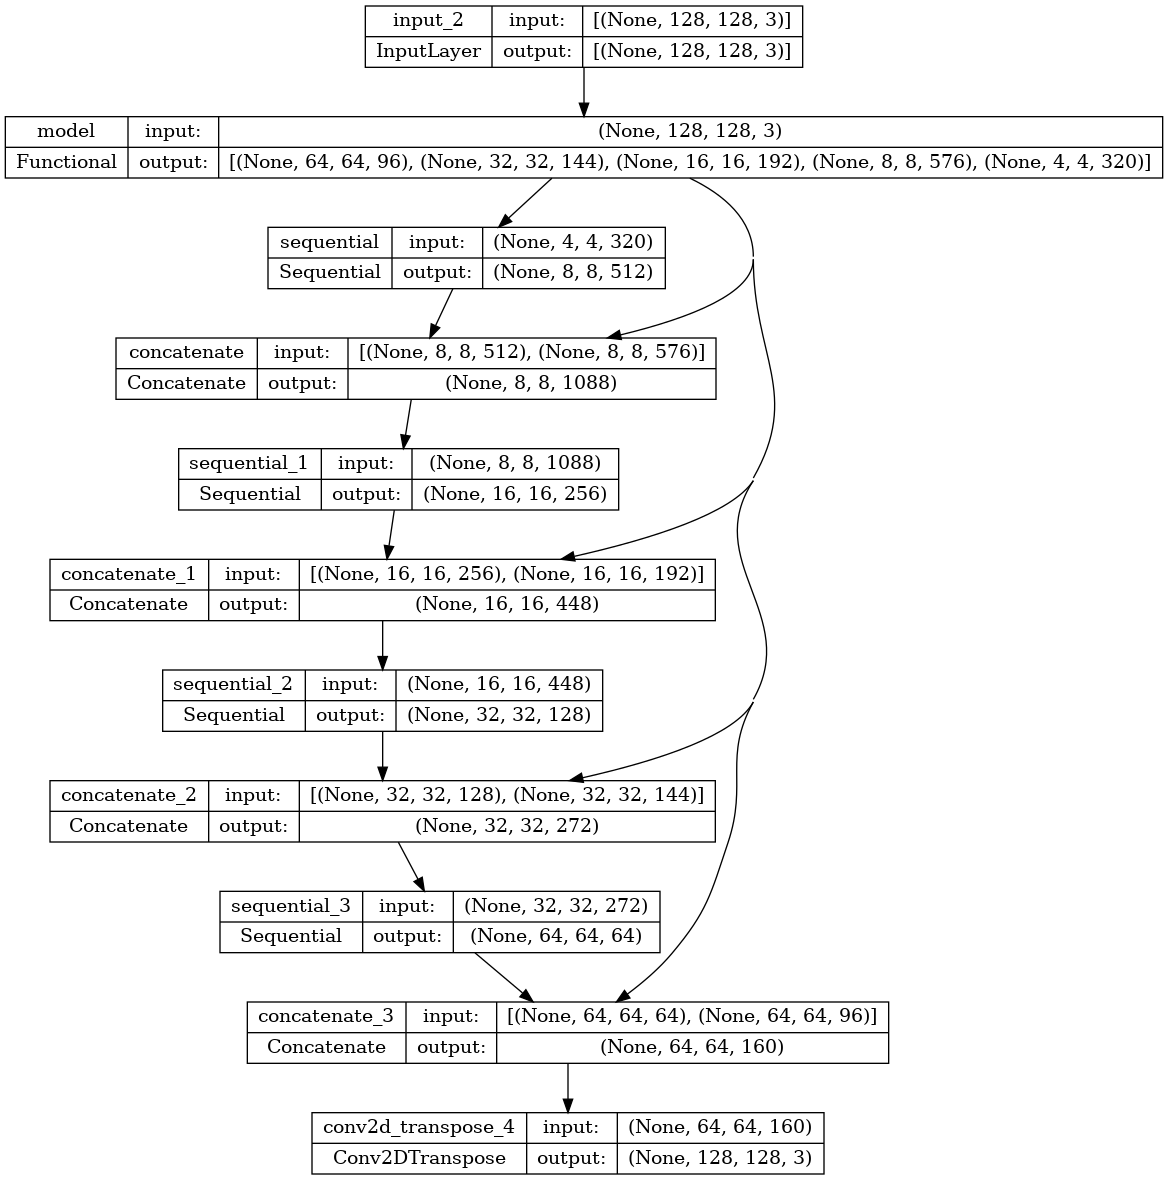

In [19]:
from IPython.display import Image
from IPython.display import display as display_image
display_image(Image(filename='segmentation_model.png'))

## Train the model

Since this is a multiclass classification problem, use the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since we are not using a `softmax` activation function, the labels are scalar integers instead of vectors of scores for each pixel of every class. More details [here](https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/)

In [20]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

Try out the model to check what it predicts before training:

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

The `show_predictions` function, displays the original image, the original mask, and the resulting mask.

In [23]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 373ms/step


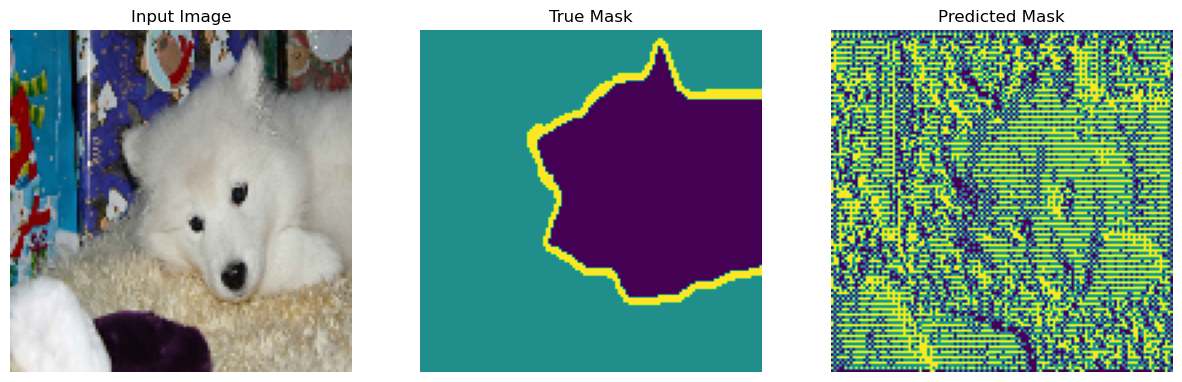

In [24]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Now we proceed to train the model with a validation set.

1/1 [==============================] - 0s 29ms/step


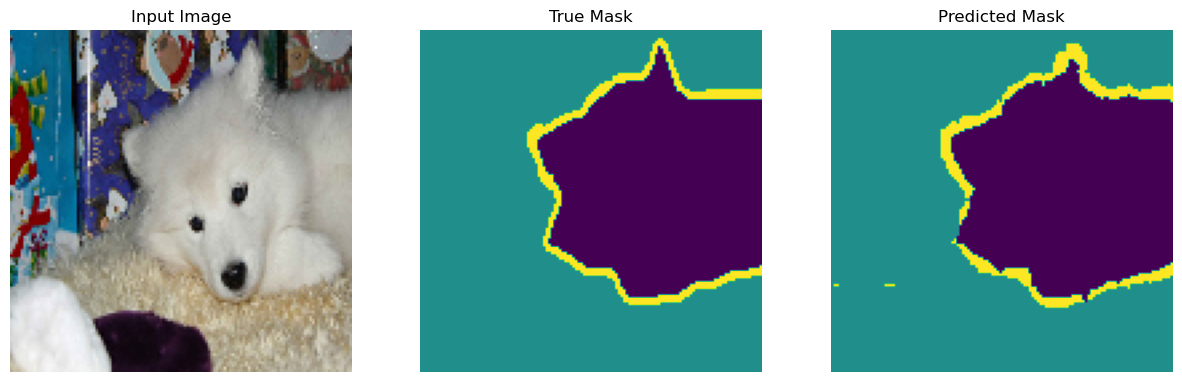


Sample Prediction after epoch 30

57/57 [==============================] - 61s 1s/step - loss: 0.0770 - accuracy: 0.9679 - val_loss: 0.4025 - val_accuracy: 0.8979


In [26]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

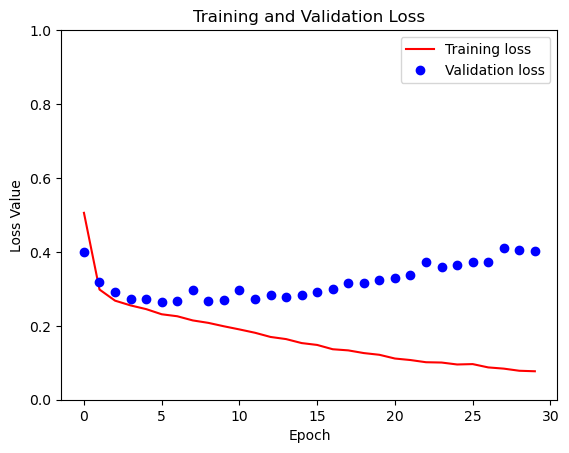

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, let's visualize the predictions using the test set.

2/2 [==============================] - 1s 241ms/step


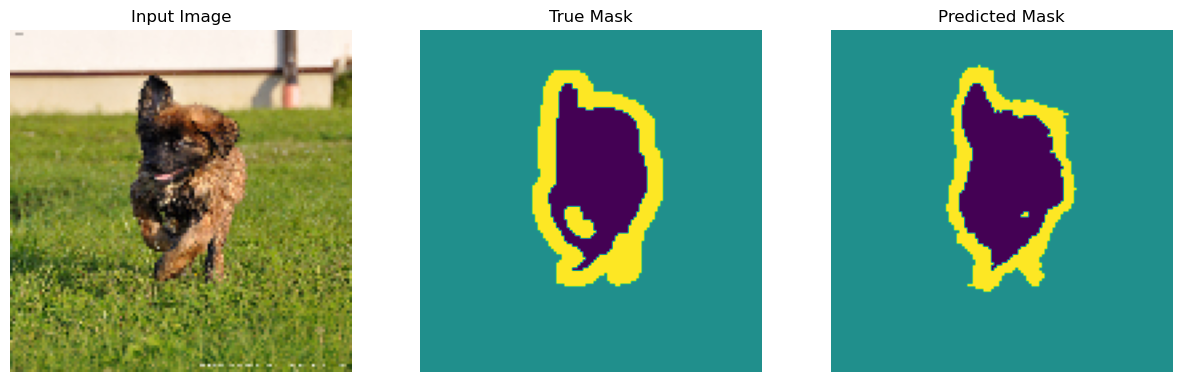

2/2 [==============================] - 0s 231ms/step


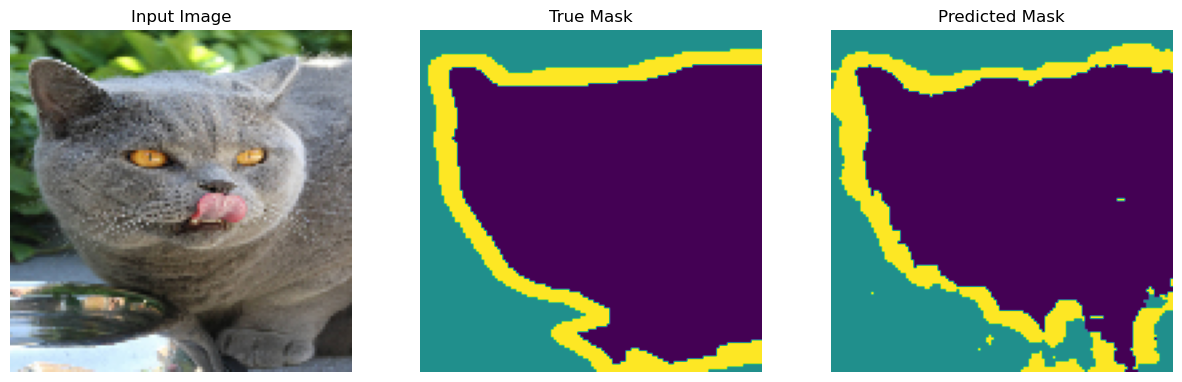

2/2 [==============================] - 0s 230ms/step


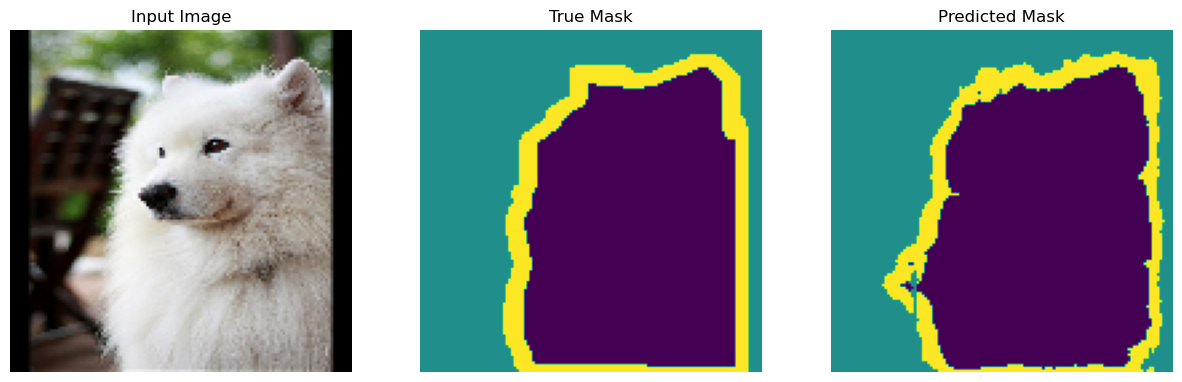

2/2 [==============================] - 0s 234ms/step


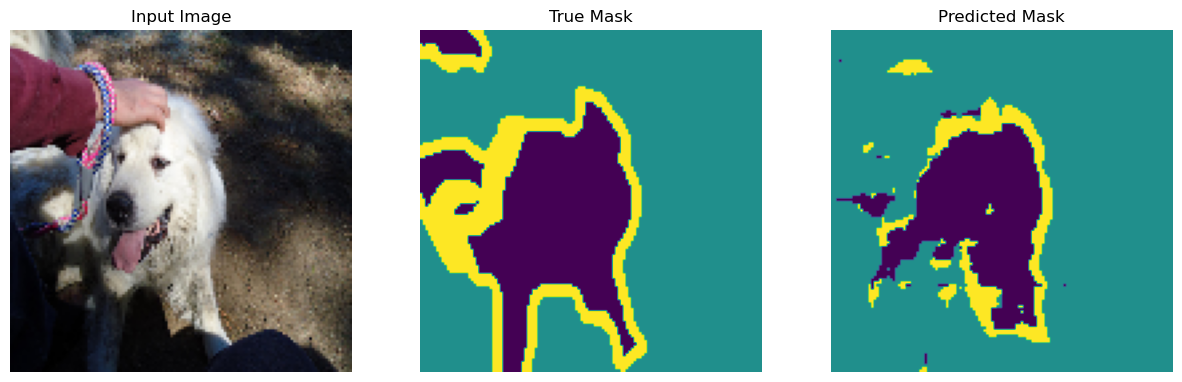

2/2 [==============================] - 1s 241ms/step


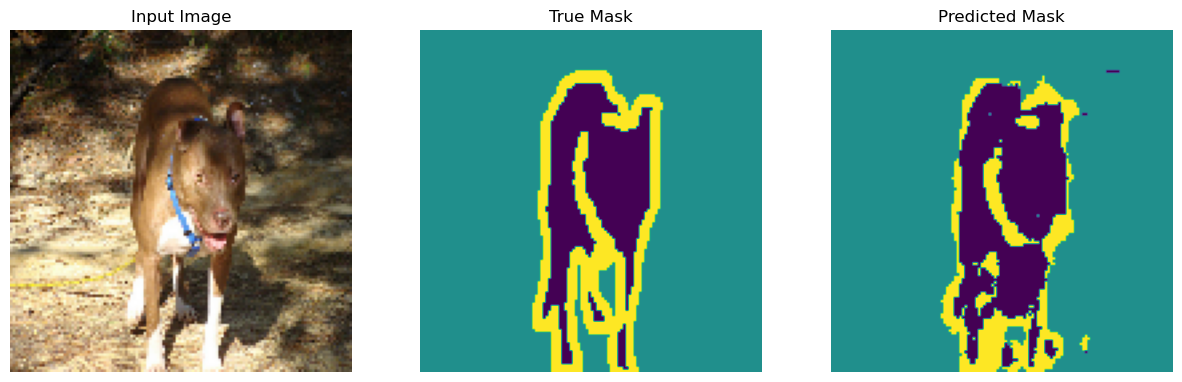

2/2 [==============================] - 0s 240ms/step


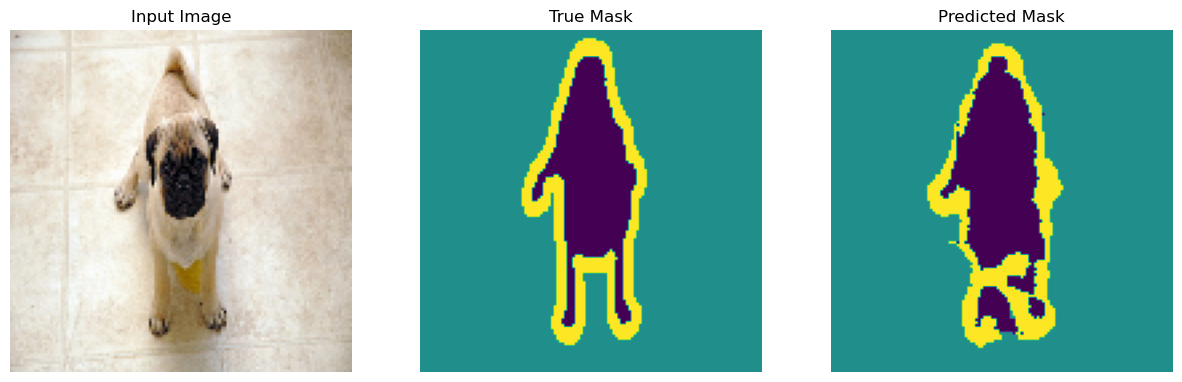

2/2 [==============================] - 0s 240ms/step


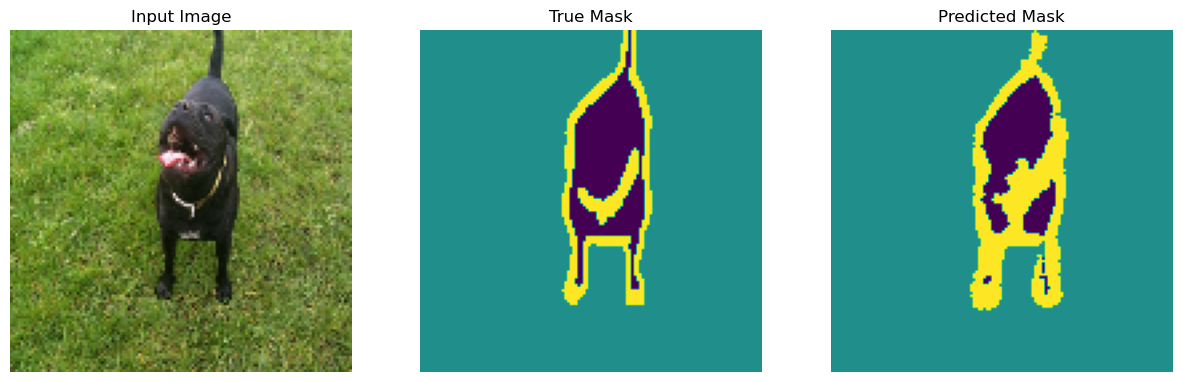

In [28]:
show_predictions(test_batches, 7)